# Frankenstein's Method Example with 4-Boint Bending
In this example we try to solve a basic beam problem using Frankenstein's method. The reference solution and tests are produced in-silico with Euler-Bernioulli solutions.

## Importing packages
These packages are required to calculate through the problem and primeraly for the interactive plots.

In [1]:
# Importing required modules.
import numpy as np

# Importing my own scripts.
import problem
import test
from configuration import ConfigurationDatabase
from patch import PatchDatabase
from constitutive import LinearMaterial, Softening

# Importing interactive plots.
from __future__ import print_function
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Show DataFrame as Table
from IPython.display import display, HTML

# Run settings for solver (pandarallel).
parallel = False

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Problem properties
The dimensions and other properties of the properties, including the axis system.

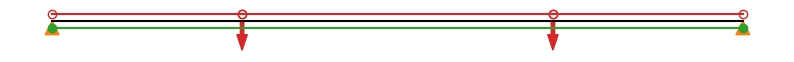

In [52]:
# Problem definition.
problem_length = 1200.  # mm
problem_load = -1  # kN
problem_ratio = 330./problem_length  # Location of the load introductions.
domain_length = 320.  # Length of the subdomains in mm.
domain_num = 4  # Number of subdomains.
problem = problem.FourPointBending(problem_length, problem_load, problem_ratio, domain_length, domain_num, continuity=2)

# Plot the problem definition.
problem.plot()

# Axis system.
x = np.linspace(0, problem_length, int(problem_length)+1)

# Material definition.
material_var_lin = 810.0  # Linear material equation constant.
material_var_nonlin = 0.3e-5  # Non-linear material equation constant.
material = Softening(material_var_lin, material_var_nonlin)

## The reference solution is based upon Euler-Bernoulli's solution
The analitical solution of the EB equations of this problem.

Text(0.5, 1.0, 'Exact')

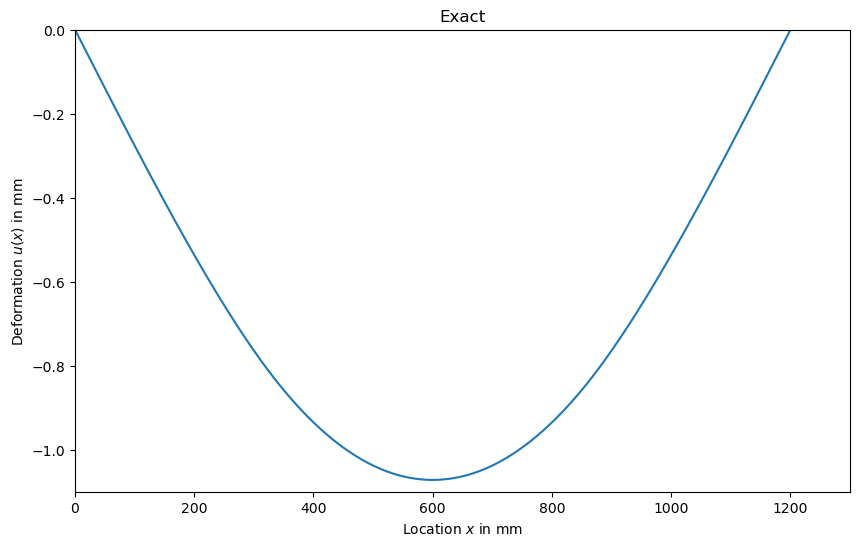

In [53]:
# Exact solution and its plot.
exact_x, exact_u, exact_moment, exact_shear = problem.exact(x, material)

# Plot exact solution.
fig = plt.figure(figsize=(10, 6))
plt.plot(exact_x, exact_u)
plt.xlabel(r'Location $x$ in mm')
plt.ylabel(r'Deformation $u(x)$ in mm')
plt.axis([0, 1300, -1.1, 0])
plt.title('Exact')

## Performing tests on another beam of the same material
We simulate the test of an other, shorter beam made of the same material. 

(<AxesSubplot:ylabel='Displacement $u$ in mm'>,
 <AxesSubplot:xlabel='Location $x$ in mm', ylabel='Moment $M$ in kNmm'>,
 <AxesSubplot:ylabel='Shear $V$ in kN'>)

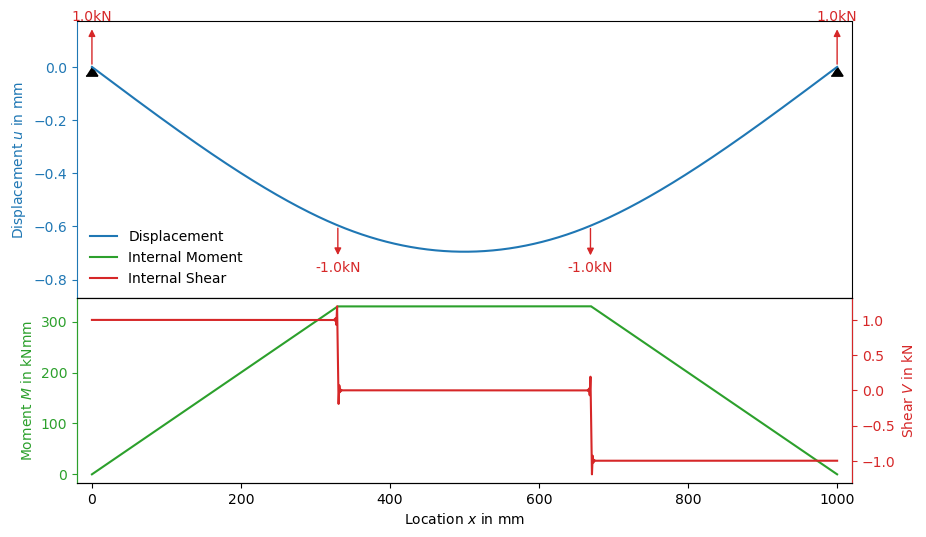

In [54]:
# The test matrix, consider the exact solution as the tested specimen.
specimen_length = 1000.  # mm specimen length.
specimen_ratio = problem_ratio*problem_length/specimen_length
specimen_load = problem_load

# Perform the testing and add the result to the database.
specimen_dx = 1.0  # mm discretization step size (DIC resolution)
test = test.FourPointBending(specimen_length, specimen_dx, specimen_load, specimen_ratio, material)

# Plotting the tested specimen.
test.plot(material)

## Spliting the tested beam into patches
From the tested beam patches are obtained. These are displacement fields that we know to be internally admissible. Afterall they were observed in "reality". Of the patches we know:
1. The entire displacement field.
2. The external loads apply to the patch.
3. The material (which for a beam inclues the cross sectional shape)

In [55]:
# Create empty database.
database = PatchDatabase()

# Fill the database.
database.add_test(test)
print("\nNumber of patches", database.num_patches())

# Plot database.
# database.plot(material)


Number of patches 1


In [56]:
# Create the set of all configurations based upon these admissible configurations.
configurations = ConfigurationDatabase.create_from_problem_patches(problem, database)

# Number of configurations.
print("Number of admissible configurations:", configurations.num_configurations())

Number of admissible configurations: 4


## Play around with a configuration.
You can select different configurations and play around with the DOFs

In [59]:
# Define a function to plot a configuration.

def plot_config(num, optimized,
               t0, u0, r0,
               t1, u1, r1,
               t2, u2, r2,
               t3, u3, r3):
    """
    Plot a configuration and interact with it.
    
    Parameters
    ----------
    num : int
        The selected configuration (0 up to 36).
    * : float
        The parameters of translation, constant displacement and rotation of each domain.
    optimized : bool
        Whether to use the optimized degrees of freedom.
    """
    # Get the configuration in question.
    configuration = configurations.database.configuration[num]
    
    # Set the translation. (checks for admissibility)
    translation = np.array([t0, t1, t2, t3])
    configuration.translation = translation
    
    # Set the rigid body motion addition to displacement.
    # print("RBD free:\n", configuration._free_rbd)
    rbd = np.array([[u0, r0],
                    [u1, r1],
                    [u2, r2],
                    [u3, r3]])
    configuration.rbd = rbd
    
    # Plot the configuration.
    configuration.plot(x, material)
    
# Create interface elements.
# generic settings.
config_selector = widgets.Dropdown(value=0, options= list(range(configurations.num_configurations())), description="Configuration number")
optimized_selector = widgets.ToggleButton(value=False, description="Optimize configuration")
general_box = widgets.HBox([config_selector, optimized_selector])

# domain 0 settings.
t0_selector = widgets.FloatSlider(value=0, min=-200, max=200, step=20,
    description='D0: Translation', orientation='horizontal',
    readout=True, readout_format='.0f')
u0_selector = widgets.FloatSlider(value=0, min=-1, max=1, step=0.05,
    description='Displacement', orientation='horizontal',
    readout=True, readout_format='.2f')
r0_selector = widgets.FloatSlider(value=0, min=-1e-2, max=1e-2, step=5e-5,
    description='Rotation', orientation='horizontal',
    readout=True, readout_format='.1e')
domain0_box = widgets.HBox([t0_selector, u0_selector, r0_selector])

# domain 1 settings.
t1_selector = widgets.FloatSlider(value=0, min=-200, max=200, step=20,
    description='D1: Translation', orientation='horizontal',
    readout=True, readout_format='.0f')
u1_selector = widgets.FloatSlider(value=0, min=-1, max=1, step=0.05,
    description='Displacement', orientation='horizontal',
    readout=True, readout_format='.2f')
r1_selector = widgets.FloatSlider(value=0, min=-1e-2, max=1e-2, step=5e-5,
    description='Rotation', orientation='horizontal',
    readout=True, readout_format='.1e')
domain1_box = widgets.HBox([t1_selector, u1_selector, r1_selector])

# domain 2 settings.
t2_selector = widgets.FloatSlider(value=0, min=-200, max=200, step=20,
    description='D2: Translation', orientation='horizontal',
    readout=True, readout_format='.0f')
u2_selector = widgets.FloatSlider(value=0, min=-1, max=1, step=0.05,
    description='Displacement', orientation='horizontal',
    readout=True, readout_format='.2f')
r2_selector = widgets.FloatSlider(value=0, min=-1e-2, max=1e-2, step=5e-5,
    description='Rotation', orientation='horizontal',
    readout=True, readout_format='.1e')
domain2_box = widgets.HBox([t2_selector, u2_selector, r2_selector])

# domain 3 settings.
t3_selector = widgets.FloatSlider(value=0, min=-200, max=200, step=20,
    description='D3: Translation', orientation='horizontal',
    readout=True, readout_format='.0f')
u3_selector = widgets.FloatSlider(value=0, min=-1, max=1, step=0.05,
    description='Displacement', orientation='horizontal',
    readout=True, readout_format='.2f')
r3_selector = widgets.FloatSlider(value=0, min=-1e-2, max=1e-2, step=5e-5,
    description='Rotation', orientation='horizontal',
    readout=True, readout_format='.1e')
domain3_box = widgets.HBox([t3_selector, u3_selector, r3_selector])

# Move all variables to optimized solutions if requested.
def update_to_optimized(*args):
    if optimized_selector.value is True:
        # Select the current configuration.
        config = configurations.database.configuration[config_selector.value]
        
        # Perform optimisation.
        config.optimize(x)
        translation = config.translation
        rbd = config.rbd
        
        # Set the optimal values.
        t0_selector.value = translation[0]
        u0_selector.value = rbd[0, 0]
        r0_selector.value = rbd[0, 1]
        t1_selector.value = translation[1]
        u1_selector.value = rbd[1, 0]
        r1_selector.value = rbd[1, 1]
        t2_selector.value = translation[2]
        u2_selector.value = rbd[2, 0]
        r2_selector.value = rbd[2, 1]
        t3_selector.value = translation[3]
        u3_selector.value = rbd[3, 0]
        r3_selector.value = rbd[3, 1]

optimized_selector.observe(update_to_optimized, 'value')

# Combining all.
settings_box = widgets.VBox([general_box, domain0_box, domain1_box, domain2_box, domain3_box])

# Resulting plot.
settings_dict = {'num': config_selector, 'optimized': optimized_selector,
                 't0': t0_selector, 'u0': u0_selector, 'r0': r0_selector,
                 't1': t1_selector, 'u1': u1_selector, 'r1': r1_selector,
                 't2': t2_selector, 'u2': u2_selector, 'r2': r2_selector,
                 't3': t3_selector, 'u3': u3_selector, 'r3': r3_selector}
plot = widgets.interactive_output(plot_config, settings_dict)

# Create interaction interface.
display(settings_box, plot)

Output()

## For each configuration find the DOFs
For each cofiguration we'll find the best DOF such that the the domain-decomposition requriement is best satisfied.

In [60]:
# Optimising the configurations and sorting them in order of error.
configurations.optimize(x)
configurations.sort('error')

# Print the results.
print("The results of all solutions.")
display(HTML(configurations.database.to_html()))

Minimizing the error equation for 4 configurations.
The results of all solutions.


,configuration,patch,translation bounds,error,rbd,du_rbd,translation,success
1,<configuration.Configuration object at 0x7faf05f98f10>,"(0, 0, 0, 0)","((0.0, 0.0), (0.0, 0.0), (201.0, 201.0), (200.0, 200.0))",1.610124e-11,"[-0.10959170728880266, -0.3105098373177015, -0.3102622074469147, -0.10965703507747876]","[-0.0006849481705550166, -0.000684948170552821, 0.0006913284080062994, 0.0006853564692342422]","[0.0, 0.0, 201.0, 200.0]",True
2,<configuration.Configuration object at 0x7faf05d98070>,"(0, 0, 0, 0)","((0.0, 0.0), (-339.0, -339.0), (540.0, 540.0), (200.0, 200.0))",2.110862e-08,"[0.03859823941080666, -0.1742105704624761, -0.17550668891040752, 0.03884845863832515]","[0.0002412389963175416, -0.0020685984436656386, 0.002073881720651251, -0.0002428028664895322]","[0.0, -339.0, 540.0, 200.0]",True
3,<configuration.Configuration object at 0x7faf064e6eb0>,"(0, 0, 0, 0)","((0.0, 0.0), (-339.0, -339.0), (201.0, 201.0), (200.0, 200.0))",4.715963e-07,"[-0.02383054246851824, -0.3510921191206051, -0.13447929662552754, -0.04761600772962151]","[-0.000148940890428239, -0.0024587783304117054, 0.0003035719870780612, 0.00029760004831013445]","[0.0, -339.0, 201.0, 200.0]",True
0,<configuration.Configuration object at 0x7faf05c59430>,"(0, 0, 0, 0)","((0.0, 0.0), (0.0, 0.0), (540.0, 540.0), (200.0, 200.0))",4.739373e-07,"[-0.04716292541213924, -0.13362828865987186, -0.3512895997308616, -0.02319256871016473]","[-0.00029476828382587024, -0.00029476828375673186, 0.0024616381415707204, 0.00014495355443852956]","[0.0, 0.0, 540.0, 200.0]",True


## The solution to the problem
The solution to the problem is the configuration with the lowest error. In this specific case a configuration has zero error, this is not just any approximation but the exact solution to the posed beam problem.

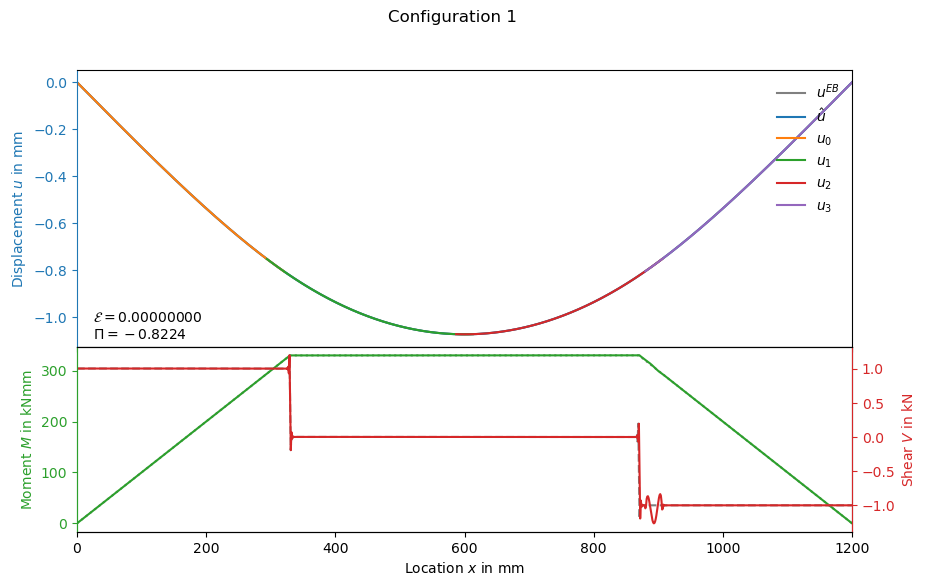

In [61]:
# Plot the best configuration.
configurations.plot(x, material, max_images=1)